In [1]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 KB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords                # stopwords are removed from text to keep just useful info
# from nltk import word_tokenize, sent_tokenize

import keras
from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from underthesea import word_tokenize
import os
print(os.listdir())

# Any results you write to the current directory are saved as output.

['.config', 'gdrive', 'sample_data']


In [18]:
# importing IMDB dataset from another source....this is done to increase our training dataset
# w/o this the max accuracy was around 88%, but using this validation set acc. increased to around 93%
df = pd.read_csv('/content/gdrive/MyDrive/NLP/Data/data.csv',encoding="utf-8")
df.head(5)


,title,category,content
0,Galaxy Gear có thể điều khiển TV thông minh,Công nghệ,Mẫu đồng hồ thông minh Galaxy Gear của Samsung...
1,Nhật – Mỹ định hội đàm chớp nhoáng tại Singapo...,Thế giới,">> Phó Tổng thống Mỹ công du châu Á, bàn về Bi..."
2,Hàng ngàn học sinh miền núi Nghệ An bỏ học,Giáo dục,Hàng ngàn học sinh sau khi tốt nghiệp THCS đã ...
3,'Cô ấy bỏ em vì... em gái trượt đại học?',Đời sống,Mr Búp Bê (BB): Hay là bạn phải đến kèm cho cô...
4,Cậu bé vượt qua Face ID của iPhone ngang anh Q...,Công nghệ,Trang Wired mới đây đưa thông tin cậu bé Ammar...


In [ ]:
df.shape

(51999, 3)

In [ ]:
df.dropna(inplace = True)
df.shape

(51999, 3)

In [ ]:
# X = df['content']
# y = df['category']

In [ ]:

with open("/content/gdrive/MyDrive/NLP/Data/stopword.txt", "r") as file:
    stopwords = []
    for readline in file: 
        line_strip = readline.strip()
        line_strip = word_tokenize(line_strip, format = 'text')
        stopwords.append(line_strip)
stopwords[0:5]

['a lô', 'a_ha', 'ai', 'ai ai', 'ai nấy']

In [ ]:
lines = [i.strip() for i in df['content']]
lines[0:5]

['Mẫu đồng hồ thông minh Galaxy Gear của Samsung - Ảnh: AFP.\nTheo SlashGear hôm 2.10, nếu tương tác với TV thông minh thì Galaxy Gear có thể đảm nhiệm một số chức năng như: chuyển kênh, tăng giảm âm lượng, tắt mở TV...\nNgoài ra, Galaxy Gear còn có khả năng theo dõi sức khỏe. Tức là các thông tin về sức khỏe của người dùng khi đeo thiết bị sẽ được phát đến TV để họ nắm được tình trạng sức khỏe của mình.\nĐược biết, hiện Galaxy Gear chỉ có thể làm việc trên các thiết bị di động của Samsung như Galaxy Note 3 và Galaxy Tab 10,1 inch. Thời gian tới, các thiết bị khác như Galaxy S4, Galaxy Note 2 cũng sẽ có bản cập nhật để tương tác được với Galaxy Gear.\nThành Luân.',
 '>> Phó Tổng thống Mỹ công du châu Á, bàn về Biển Đông.\n>> Nhật có thể ký thỏa thuận quân sự với Philippines.\nThủ tướng Nhật Bản Shinzo Abe.\nDự kiến trong cuộc hội đàm, hai nhà lãnh đạo sẽ tái khẳng định cam kết thúc đẩy hợp tác song phương Tokyo-Washington. Bên cạnh đó, theo nguồn tin của Kyodo, ông Abe sẽ trao đổi với 

In [ ]:
'''
Here we will do preprocessing
1. Removing punctuations
2. Lowering all words
3. removing non-alphabet things
4. removing stop words
5. Tokenizing the sentence
'''
from underthesea import word_tokenize
import string

review_lines = list()

for line in lines:
    
    '''
    breaks line into it's sub parts like each word and comma etc,
    https://pythonspot.com/tokenizing-words-and-sentences-with-nltk/
    '''
    tokens = word_tokenize(line)   
    
     #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    # brief detail: https://pythonadventures.wordpress.com/2017/02/05/remove-punctuations-from-a-text/
    table = str.maketrans('','', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
     
    # remove remaining tokens that are not alphabetic
    words = [w for w in stripped if w.isalpha()]
    
    # filter out stop words
    stop_words = set(stopwords)
    words = [w for w in words if w not in stop_words]
    
    review_lines.append(words)
review_lines[0:5]

[['mẫu',
  'samsung',
  'ảnh',
  'afp',
  'slashgear',
  'hôm',
  'tv',
  'kênh',
  'tắt',
  'đeo',
  'phát',
  'tv',
  'nắm',
  'hiện',
  'samsung',
  'inch',
  'galaxy',
  'gear'],
 ['mỹ',
  'bàn',
  'ký',
  'philippines',
  'hai',
  'tái',
  'tokyowashington',
  'kyodo',
  'abe',
  'mỹ',
  'biển',
  'malaysia',
  'singapore',
  'philippines',
  'abe',
  'asean',
  'diễn',
  'dấy',
  'asean',
  'coc',
  'đảo',
  'senkaku',
  'điếu',
  'ngư',
  'biển',
  'tokyo',
  'mỹ',
  'chuyến',
  'kéo',
  'tài',
  'tuần',
  'singapore',
  'tuần'],
 ['hàng',
  'ngàn',
  'thcs',
  'dự',
  'thi',
  'huyện',
  'thcs',
  'dự',
  'thi',
  'trường',
  'thcs',
  'học',
  'xong',
  'lớp',
  'đi',
  'học',
  'nghề',
  'đường',
  'huyện',
  'miền',
  'núi',
  'dạy',
  'nghề',
  'đi',
  'học',
  'nghề'],
 ['mr',
  'bb',
  'kèm',
  'học',
  'đỗ',
  'đỗ',
  'yêu',
  'kèm',
  'học',
  'nằm',
  'đỗ',
  'trượt',
  'lắm',
  'hazzzzz',
  'đi',
  'học',
  'muộn',
  'gửi',
  'mail',
  'tiện',
  'hả',
  'bb',
  'vũ',


In [ ]:
review_liness = []
for word in review_lines:
  result = " ".join(w for w in word)
  review_liness.append(result)


In [ ]:
review_liness[0:10]

['mẫu samsung ảnh afp slashgear hôm tv kênh tắt đeo phát tv nắm hiện samsung inch galaxy gear',
 'mỹ bàn ký philippines hai tái tokyowashington kyodo abe mỹ biển malaysia singapore philippines abe asean diễn dấy asean coc đảo senkaku điếu ngư biển tokyo mỹ chuyến kéo tài tuần singapore tuần',
 'hàng ngàn thcs dự thi huyện thcs dự thi trường thcs học xong lớp đi học nghề đường huyện miền núi dạy nghề đi học nghề',
 'mr bb kèm học đỗ đỗ yêu kèm học nằm đỗ trượt lắm hazzzzz đi học muộn gửi mail tiện hả bb vũ liên gửi thư tem xông xênh gọi ổn thăm thăm yêu mong chả tặng tượng sứ hình hai hươu chụm đầu gặm cỏ bảo chúc mày đừng bb bb hai hươu gặm cỏ gợi chàng trai quà tặng bb gửi câu chờ',
 'bé đăng nhập iphone x mẹ trông bố hồi đầu học lớp phòng iphone x mua bé thử iphone x cài bé nhặt mẹ khóa vòng nửa giây malik bé trông bố sốc bé vợ bé đọc vợ xóa nhắn sợ ammar malik apple gọi sai triệu cặp cặp malik mẹ face id ammar thử malik khóa tỏ mặt trai mặt mẹ hai malik wired malik kỹ đứa trẻ iphone

In [ ]:
def save_Content(ListContent, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for item in ListContent:
            f.write("%s\n" % item)
        f.close()


In [ ]:
save_Content(review_liness, "/content/gdrive/MyDrive/NLP/Data/New_Clean_data_Content.txt")

In [4]:

def read_file(file):
    with open(file, 'r', encoding='utf-8') as f:
        line = f.readlines()
        lines = list(m.replace("\n","") for m in line)
        # print(line)
    f.close()
    return lines

In [5]:
Content = read_file("/content/gdrive/MyDrive/NLP/Data/New_Clean_data_Content.txt")

In [6]:
Content[0:5]

['mẫu samsung ảnh afp slashgear hôm tv kênh tắt đeo phát tv nắm hiện samsung inch galaxy gear',
 'mỹ bàn ký philippines hai tái tokyowashington kyodo abe mỹ biển malaysia singapore philippines abe asean diễn dấy asean coc đảo senkaku điếu ngư biển tokyo mỹ chuyến kéo tài tuần singapore tuần',
 'hàng ngàn thcs dự thi huyện thcs dự thi trường thcs học xong lớp đi học nghề đường huyện miền núi dạy nghề đi học nghề',
 'mr bb kèm học đỗ đỗ yêu kèm học nằm đỗ trượt lắm hazzzzz đi học muộn gửi mail tiện hả bb vũ liên gửi thư tem xông xênh gọi ổn thăm thăm yêu mong chả tặng tượng sứ hình hai hươu chụm đầu gặm cỏ bảo chúc mày đừng bb bb hai hươu gặm cỏ gợi chàng trai quà tặng bb gửi câu chờ',
 'bé đăng nhập iphone x mẹ trông bố hồi đầu học lớp phòng iphone x mua bé thử iphone x cài bé nhặt mẹ khóa vòng nửa giây malik bé trông bố sốc bé vợ bé đọc vợ xóa nhắn sợ ammar malik apple gọi sai triệu cặp cặp malik mẹ face id ammar thử malik khóa tỏ mặt trai mặt mẹ hai malik wired malik kỹ đứa trẻ iphone

In [22]:
from underthesea import word_tokenize

def read_data(List_word):
    traindata = []
    for sent in List_word:
        traindata.append(word_tokenize(sent))
    return traindata

In [24]:
train_data = read_data(Content)
train_data[0:5]

[['mẫu',
  'samsung',
  'ảnh',
  'afp',
  'slashgear',
  'hôm',
  'tv',
  'kênh',
  'tắt',
  'đeo',
  'phát',
  'tv',
  'nắm',
  'hiện',
  'samsung',
  'inch',
  'galaxy',
  'gear'],
 ['mỹ',
  'bàn',
  'ký',
  'philippines',
  'hai',
  'tái',
  'tokyowashington',
  'kyodo',
  'abe',
  'mỹ',
  'biển',
  'malaysia',
  'singapore',
  'philippines',
  'abe',
  'asean',
  'diễn',
  'dấy',
  'asean',
  'coc',
  'đảo',
  'senkaku',
  'điếu',
  'ngư',
  'biển',
  'tokyo',
  'mỹ',
  'chuyến',
  'kéo',
  'tài',
  'tuần',
  'singapore',
  'tuần'],
 ['hàng',
  'ngàn',
  'thcs',
  'dự',
  'thi',
  'huyện',
  'thcs',
  'dự',
  'thi',
  'trường',
  'thcs',
  'học',
  'xong',
  'lớp',
  'đi',
  'học',
  'nghề',
  'đường',
  'huyện',
  'miền',
  'núi',
  'dạy',
  'nghề',
  'đi',
  'học',
  'nghề'],
 ['mr',
  'bb',
  'kèm',
  'học',
  'đỗ',
  'đỗ',
  'yêu',
  'kèm',
  'học',
  'nằm',
  'đỗ',
  'trượt',
  'lắm',
  'hazzzzz',
  'đi',
  'học',
  'muộn',
  'gửi',
  'mail',
  'tiện',
  'hả',
  'bb',
  'vũ',


In [26]:
'''
gensim is python library for training word embeddings in given data
for more information visit: 
1. https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
2. http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XEoWKVwzbIV
'''
import gensim
import multiprocessing

cores = multiprocessing.cpu_count()

embedding_vector_size = 300
# now training embeddings for each word 
w2v_model = gensim.models.Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

# # to get total number of unique words
# words = list(model_1.wv.vocab)

# print("vocab size:", len(words))

In [27]:
from time import time
t = time()

w2v_model.build_vocab(train_data, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.02 mins


In [28]:
t = time()

w2v_model.train(train_data, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 6.41 mins


In [29]:
w2v_model.save("/content/gdrive/MyDrive/NLP/Data/word2vec_Embedding.model")

In [ ]:
# w2v_model = gensim.models.Word2Vec.load("word2vec_Embedding.model")

In [30]:
# getting the training loss value
training_loss = w2v_model.get_latest_training_loss()
print(training_loss)

0.0


In [32]:
w2v_model.wv.most_similar(positive=["hoa"], topn = 10)

[('hoa màu', 0.56458979845047),
 ('nhụy', 0.5366659164428711),
 ('vườn hoa', 0.4970857501029968),
 ('đơm', 0.476397842168808),
 ('lẵng', 0.46869993209838867),
 ('đóa', 0.45273357629776),
 ('hương', 0.4418981969356537),
 ('héo', 0.43443670868873596),
 ('kiểng', 0.4329260289669037),
 ('nở', 0.4311906397342682)]

Text(0, 0.5, 'frequency')

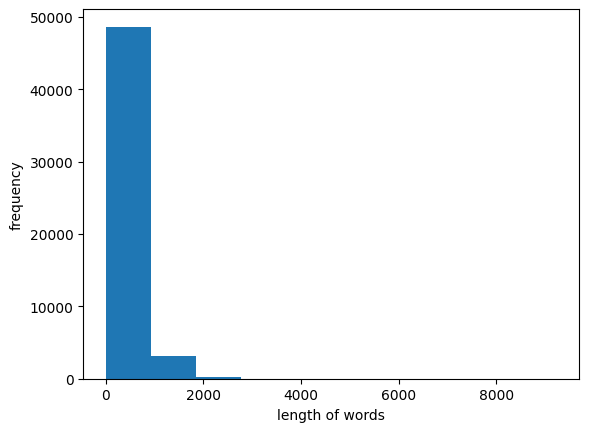

In [33]:
#len(sequence)
leng=0
length = [(leng + len(x)) for x in Content]
plt.hist(length)
plt.xlabel('length of words')
plt.ylabel('frequency')

In [14]:
import math
avg_length = sum(length)/len(Content)

# if words are more than max_length then they are skipped, if less than padding with 0 is done
print(avg_length)

395.94505663570453


In [65]:
#max_len = math.ceil(avg_length)             # this is used to decide how man words in seq to keep
max_len = math.ceil(avg_length) 
max_len

396

In [16]:
'''
Now we have trained the embeddings, we now have embedding vector for each word. We will
convert our text training data to numeric using theseword embeddings.
First, we need to make length of each input same, therefore we'll do padding. But padding happends 
on numeric data, therefore we'll convert texts to sequences using tokenize() function. Then add padding
Then we'll replace each non-zero numeric resulted from texts to sequences to its corresponding word
embedding.
'''
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
train_test_data = Content                       # contains word tokens extracted from lines
tokenizer.fit_on_texts(train_test_data)
sequence = tokenizer.texts_to_sequences(train_test_data)
train_test_data = pad_sequences(sequence, maxlen = max_len)

In [72]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

68850

In [ ]:
# Preparing embedding matrix
vocab_size = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
# +1 is done because i starts from 1 instead of 0, and goes till len(vocab)
for  word, i in tokenizer.word_index.items():
    try:
      embedding_vector = w2v_model.wv[word]
    except:
      print("error")
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    # print(i)

In [36]:
train_test_data.shape

(51999, 396)

In [ ]:
def replace(a):
  a = a.replace(" ","_")
  return a
df['category'].apply(replace)

In [66]:
y = []
for i in df.category:
  y.append(i)

In [67]:
from sklearn.preprocessing import LabelEncoder
Label = LabelEncoder()
label_new = Label.fit_transform(y)


In [68]:
label_new

array([0, 7, 1, ..., 3, 3, 3])

In [63]:
train_test_data

array([[   0,    0,    0, ...,  746,  515, 1622],
       [   0,    0,    0, ...,   84,  471,   84],
       [   0,    0,    0, ...,    2,   20,  157],
       ...,
       [   0,    0,    0, ...,  412,  210,   76],
       [   0,    0,    0, ...,  245,    7, 4207],
       [   0,    0,    0, ..., 1208,  332, 2324]], dtype=int32)

In [69]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(label_new)

In [ ]:
# X = train_test_data[:ntrain,:]
# X = np.append(X,train_test_data[ntrain+25000: ,:])
# X = X.reshape(-1,123)
# y1 = y.append(imdb_data['sentiment'])

In [70]:
X_train, X_test, y_train, y_test = train_test_split(train_test_data , y, test_size=0.2, random_state=42, shuffle=True)

In [77]:
model = Sequential()

model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                    input_length = max_len, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(64, dropout=0.25)))
model.add(Dense(10))
model.add(Dropout(0.3))
model.add(Dense(13, activation='sigmoid'))

In [75]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [78]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, epochs = 30, batch_size = 700, validation_data=(X_test, y_test),callbacks = [learning_rate_reduction])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 396, 300)          20655000  
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 13)                143       
                                                                 
Total params: 20,843,313
Trainable params: 20,843,313
Non-trainable params: 0
__________________________________________

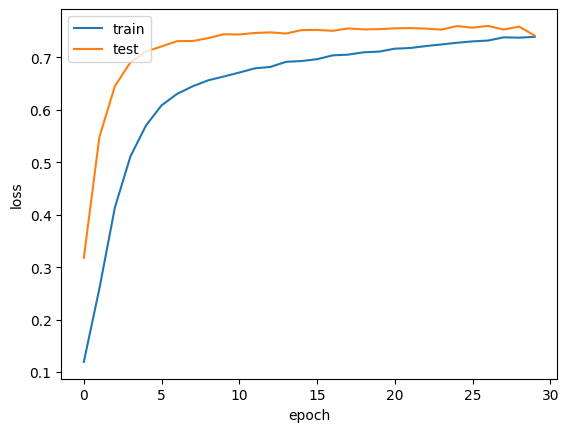

In [79]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [80]:
y_test_pred = model.predict(X_test)


325/325 [==============================] - 4s 10ms/step


In [81]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred, average = 'weighted')

0.9585078658099642

In [82]:
#predicting test_data
y_pred = model.predict(X_test)

325/325 [==============================] - 3s 10ms/step


In [83]:
# predictions = [1 if (x>0.5) else 0 for x in y_pred ]

ValueError: ignored

In [ ]:
predictions = pd.Series(predictions)

In [ ]:
ids = raw_test_data['id'].str.replace('"', '')

In [ ]:
submission = pd.DataFrame({'id': ids, 'sentiment':predictions})
submission.to_csv('word2vec.csv',index=False)